# 기본 분류 - 의류 이미지 분류(with keras)

## 0. 기본 라이브러리 불러오기

In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf

# Helper Library
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


## 1. 패션 MNIST 데이터셋 불러오기

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용해보자.<br/>
이미지는 해상도(28$\times$28)가 낮고 개별 옷 품목을 나타낸다.

<img src="https://tensorflow.org/images/fashion-mnist-sprite.png?hl=ko" width="500px" height="500px" title="패션-MNIST 샘플 (Zalando, MIT License)" align='left'/>

여기에서는 70,000개의 이미지 중 60,000개의 이미지를 사용하여 네트워크를 훈련하고,<br/> 10,000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가한다.<br/>

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

"load_data()" 함수를 호출하면 4개의 넘파이 배열이 반환된다.<br/>
* train_images와 train_labels 배열은 <span style='background-color:#fff5b1'>모델 학습에 사용되는 훈련 세트</span>이다.
* test_images와 test_labels 배열은 <span style='background-color:#fff5b1'>모델 테스트에 사용되는 테스트 세트</span>이다.<br/>

<span style='background-color:#fff5b1'>이미지</span>는 28$\times$28 크기의 <span style='background-color:#fff5b1'>넘파이 배열</span>이고 <span style='background-color:#fff5b1'>픽셀 값은 0과 255 사이</span>이다.<br/>
<span style='background-color:#fff5b1'>레이블</span>은 0부터 9까지의 <span style='background-color:#fff5b1'>정수 배열</span>이다. 이 값은 이미지에 있는 <span style='background-color:#fff5b1'>옷의 클래스</span>를 나타낸다.

|레이블|클래스|
|:---:|:---:|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shrit|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

각 이미지는 하나의 레이블에 매핑되어있다.<br/>
데이터셋에 클래스 이름이 들어가있지 않기 때문에 나중에 이미지를 출력 할 때 사용하기 위해 별도의 변수를 만들어 저장한다.

In [4]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 2. 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조를 살펴보자.

In [5]:
print(train_images.shape)
print(len(train_labels))
print(train_labels)

(60000, 28, 28)
60000
[9 0 0 ... 3 0 5]


훈련 세트에는 60,000개의 이미지가 있고, 각 이미지 픽셀은 28$\times$28 픽셀로 표현된다는 것을 보여준다.<br/>
또, 훈련 레이블에는 60,000개의 레이블이 있고, 각 레이블은 0부터 9 사이의 정수이다.

In [6]:
print(test_images.shape)
print(len(test_labels))

(10000, 28, 28)
10000


테스트 세트에는 10,000개의 이미지가 있고, 훈련 세트와 마찬가지로 28$\times$28 픽셀로 표현된다.<br/>
또 10,000개의 이미지에 대한 레이블을 가지고 있다.

## 3. 데이터 전처리

<span style='background-color:#ffdce0'>네트워크를 훈련하기 전에 데이터를 전처리 해야한다.</span><br/>
훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0 ~ 255 사이임을 알 수 있다.

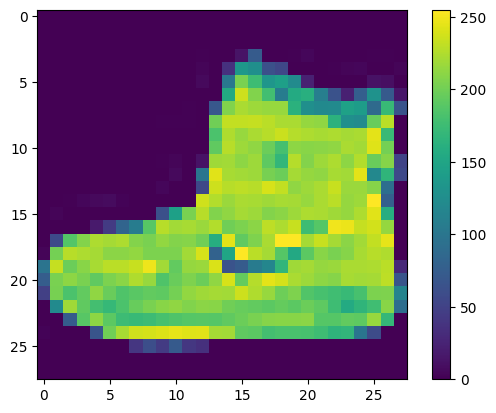

In [7]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0.0 ~ 1.0 사이로 조정해보자. 이렇게 하려면 255로 나누어야 한다.<br/>
<span style='background-color:#ffdce0'>훈련 세트와 테스트 세트를 동일한 방식으로 전처리 하는것이 중요하다.</span>

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

훈련 세트에서 처음 25개의 이미지와 그 아래 클래스 이름을 출력해보자.<br/>
데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련 준비를 마친다.

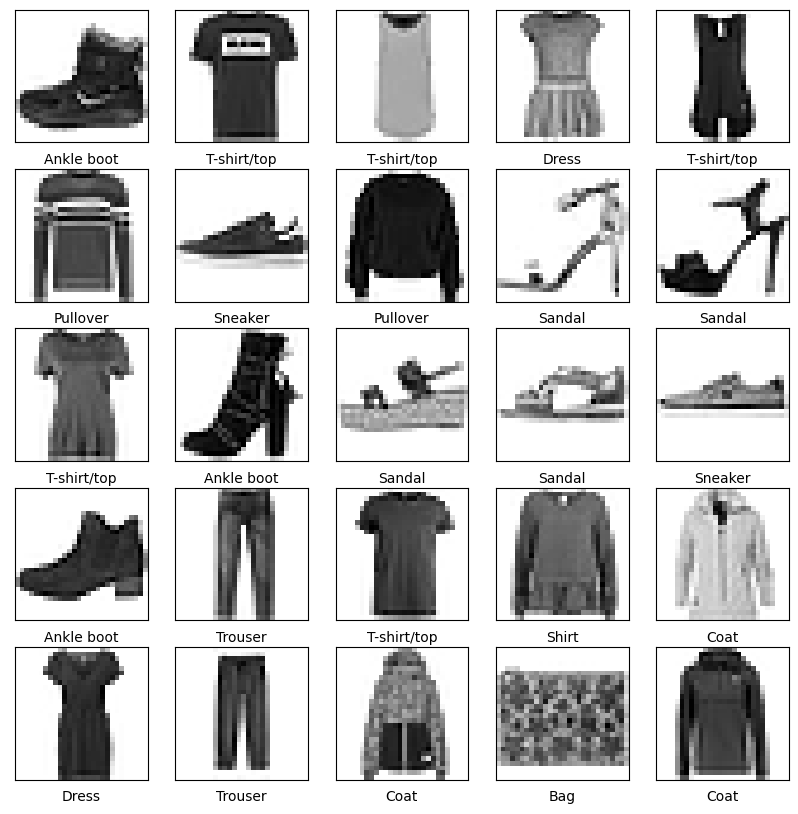

In [9]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_name[train_labels[i]])
plt.show()

## 4. 모델 구성

신경망 모델을 만들려면 <span style='background-color:#ffdce0'>모델의 층을 구성한 다음 컴파일한다.</span>

### 4-1 층 설정

신경망의 기본 빌딩 블록은 [레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers?hl=ko)이다.<br/>
<span style='background-color:#fff5b1'>레이어는 레이어에 공급된 데이터로부터 표현을 추출한다.</span> 이러한 표현은 당면한 문제에 의미가 있어야 한다.

대부분의 딥러닝은 간단한 층을 연결하여 구성된다.<br/>
[tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=ko)와 같은 층들의 파라미터는 훈련하는 동안 학습된다.

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

이 네트워크의 첫번째 층인 'tf.keras.layers.Flatten'은 2차원 배열(28$\times$28 픽셀)의 이미지 포맷을 28$\times$28 = 784 픽셀의 1차원 배열로 반환한다.<br/>
이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘린다.<br/>
이 층에는 학습되는 가중치가 없고 데이터를 반환하기만 한다.

픽셀을 펼친 후에는 두 개의 'tf.keras.layers.Dense'층이 연속되어 연결된다.<br/>
이 층을 <span style='background-color:#fff5b1'>밀집 연결(densely-connected) 또는 완전 연결(fully-connected)층</span> 이라고 부른다.<br/>
첫 번째 Dense층은 128개의 뉴런(노드)을 가진다.<br/>
두 번째 층은 10개의 노드의 softmax층이다. 이 층은 10개의 확률을 반환하고 반환된 값 전체 합은 1이다.<br/>
각 노드는 이미지가 10개 클래스 중 하나에 속할 확률을 출력한다.

### 4-2 모델 컴파일

모델을 훈련할 준비가 되기 전에 몇 가지 설정이 더 필요하다. 다음은 모델의 [컴파일](https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=ko#compile)단계에서 추가된다.

* <span style='background-color:#ffdce0'>[손실 함수](https://www.tensorflow.org/api_docs/python/tf/keras/losses?hl=ko) : 훈련 중 모델이 얼마나 정확한지 측정한다.</span> 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화 해야 한다.
* <span style='background-color:#ffdce0'>[옵티마이저](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers?hl=ko) : 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식이다.</span>
* <span style='background-color:#ffdce0'>[매트릭](https://www.tensorflow.org/api_docs/python/tf/keras/metrics?hl=ko) : 훈련 및 테스트 단계를 모니터링하는데 사용된다.</span> 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용한다.

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 5. 모델 훈련

신경망 모델을 훈련하려면 다음과 같은 단계가 필요하다.<br/>
1. 훈련 데이터를 모델에 주입한다 - 이 예에서는 ```train_images```와 ```train_labels``` 배열이다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배운다.
3. 테스트 세트에 대한 모델의 예측을 만든다 - 이 예에서는 ```test_images``` 배열이다. 이 예측이 ```test_labels``` 배열의 레이블과 맞는지 확인한다.
4. 예측이 ```test_labels``` 배열의 레이블과 일치하는지 확인한다.

### 5-1 모델 피드

훈련을 시작하려면 ```model.fit``` 메서드를 호출한다.<br/>
모델을 훈련 데이터에 "맞추기(fit)"때문에 이렇게 불린다.

In [12]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 1s 643us/step - loss: 0.5030 - accuracy: 0.8228
Epoch 2/10
1875/1875 [==============================] - 1s 639us/step - loss: 0.3744 - accuracy: 0.8658
Epoch 3/10
1875/1875 [==============================] - 1s 640us/step - loss: 0.3372 - accuracy: 0.8777
Epoch 4/10
1875/1875 [==============================] - 1s 640us/step - loss: 0.3118 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 1s 641us/step - loss: 0.2937 - accuracy: 0.8917
Epoch 6/10
1875/1875 [==============================] - 1s 638us/step - loss: 0.2794 - accuracy: 0.8964
Epoch 7/10
1875/1875 [==============================] - 1s 639us/step - loss: 0.2660 - accuracy: 0.9013
Epoch 8/10
1875/1875 [==============================] - 1s 642us/step - loss: 0.2558 - accuracy: 0.9049
Epoch 9/10
1875/1875 [==============================] - 1s 640us/step - loss: 0.2456 - accuracy: 0.9074
Epoch 10/10
1875/1875 [==============================] - 1s 642u

모델이 훈련되면서 손실(loss)과 정확도(accuracy)가 출력된다.<br/>
이 모델은 훈련 세트에서 대략 91%의 정확도를 얻었다.

### 5-2 정확도 평가

다음으로, 모델이 테스트 데이터세트에서 작동하는 방식을 비교한다.

In [13]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy :', test_accuracy)

313/313 - 0s - loss: 0.3219 - accuracy: 0.8889

Test accuracy : 0.8888999819755554


테스트 데이터의 정확도가 훈련 세트의 정확도보다 조금 낮다.<br/>
이는 <span style='background-color:#ffdce0'>과대적합(Overfitting)</span>때문이다.<br/>
<span style='background-color:#fff5b1'>과대적합이란 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상을 말한다.</span><br/>
과대적합을 방지하기 위한 전략은 다음에 배워보자.

### 5-3 예측하기

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있다.<br/>
소프트맥스 레이어를 연결하여 [로짓](https://developers.google.com/machine-learning/glossary?hl=ko#logits)을 해석하기 쉬운 확률로 변환한다.

In [14]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [15]:
predictions = probability_model.predict(test_images)

여기서는 테스트 세트에 있는 각 이미지의 레이블을 예측했다.<br/>
첫 번째 예측을 확인해보자.

In [16]:
predictions[0]

array([3.8686134e-09, 8.9901642e-09, 4.9100730e-11, 1.6618628e-12,
       2.4073732e-10, 4.6803558e-04, 6.8384075e-08, 1.0413233e-02,
       2.2334412e-07, 9.8911834e-01], dtype=float32)

이 예측은 10개의 숫자 배열로 나타난다.<br/>
이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타낸다. 가장 높은 신뢰도를 가진 레이블을 찾아보자.

In [17]:
np.argmax(predictions[0])

9

모델은 이 이미지가 앵클부츠(```class_name[9]```)라고 확신하고 있다. 이 값이 맞는지 테스트 레이블을 확인해보자.

In [18]:
test_labels[0]

9

10개의 클래스에 대한 예측을 모두 그래프로 표현해보자.

In [19]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color='blue'
    else:
        color='red'
        
    plt.xlabel('{} {:2.0f}% ({})'.format(class_name[predicted_label],
                                        100*np.max(predictions_array),
                                        class_name[true_label]), color=color)
    
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 5-4 예측 확인

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있다.<br/>
0번째 원소 이미지, 예측, 신뢰도 점수 배열을 확인해보자.

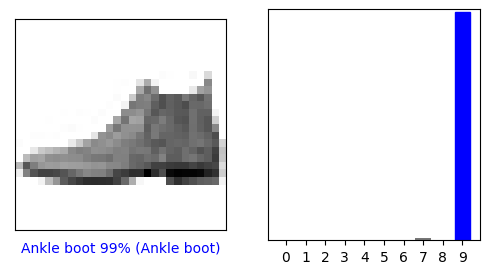

In [20]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

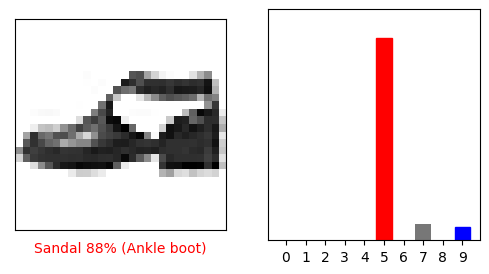

In [21]:
i = 23
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해보자.<br/>
올바르게 예측된 레이블은 파란색이고, 잘못 예측된 레이블은 빨간색이다.<br/>
숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)이다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있다.

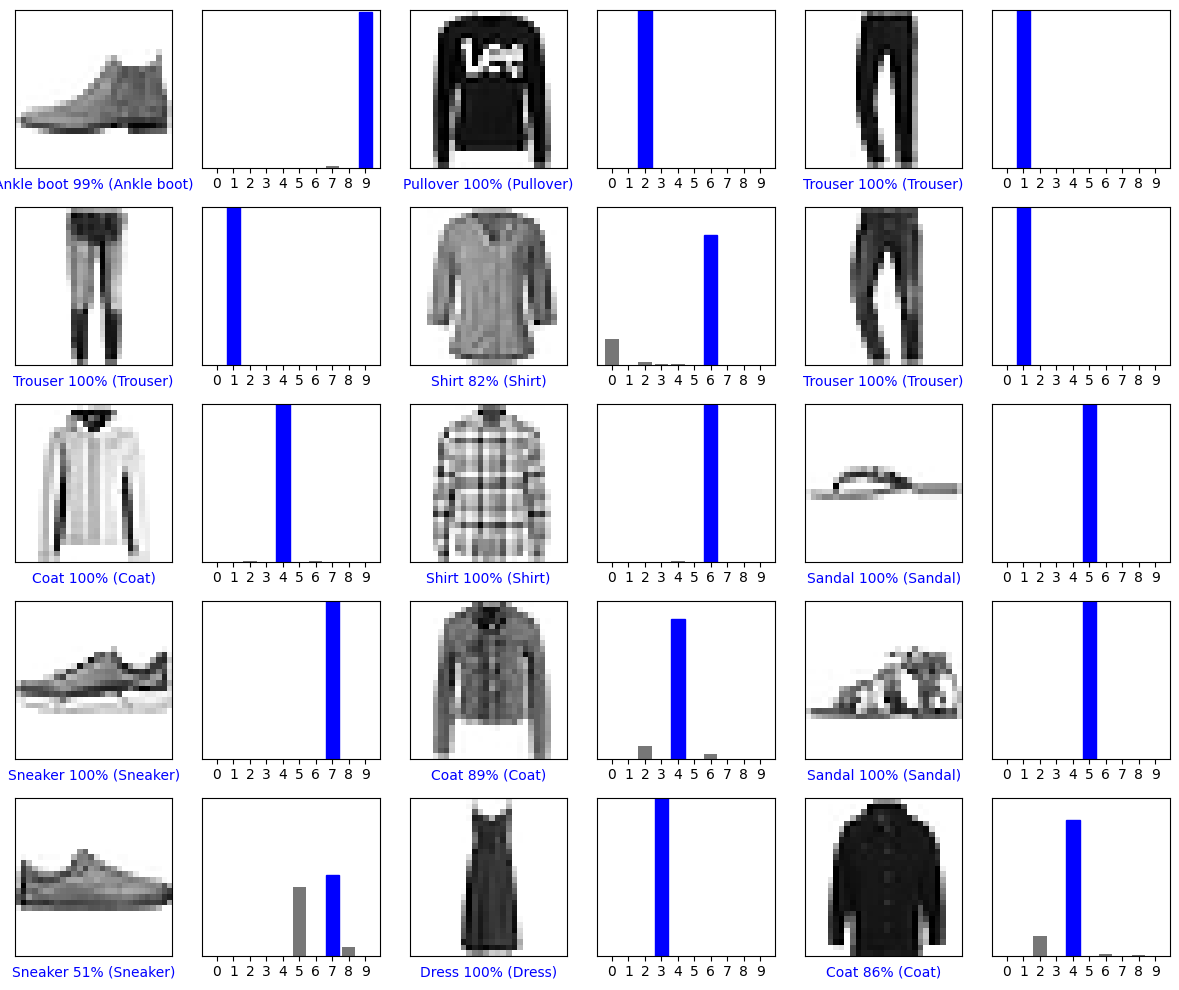

In [22]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()